# Olist : clusterisation - maintenance

In [18]:
#librairies import

import pandas as pd
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

from scipy.stats import kstest, norm, expon, uniform

In [19]:
data = pd.read_csv('data/data_with_clustering.csv')
data.head()

,last_purchase,days_since_last_purchase,total_price_items,total_freight_value,total_orders,km_enriched_cluster,DBSCAN_cluster
0,1.534792e+09,864,729.62,172.42,17,2,-1
1,1.519757e+09,1038,1000.85,171.82,9,2,-1
2,1.530147e+09,917,664.20,94.63,7,2,-1
3,1.527853e+09,944,806.61,316.11,7,2,-1
4,1.518615e+09,1051,855.21,165.91,7,2,-1


In [20]:
'''#Model import

joblib_file = "kmeans_model.pkl"
kmeans_original = joblib.load(joblib_file)'''

'#Model import\n\njoblib_file = "kmeans_model.pkl"\nkmeans_original = joblib.load(joblib_file)'

### ARI analysis

In [21]:
#drop clustering
data = data.drop(columns = ['km_enriched_cluster', 'DBSCAN_cluster'])
data.head()

,last_purchase,days_since_last_purchase,total_price_items,total_freight_value,total_orders
0,1.534792e+09,864,729.62,172.42,17
1,1.519757e+09,1038,1000.85,171.82,9
2,1.530147e+09,917,664.20,94.63,7
3,1.527853e+09,944,806.61,316.11,7
4,1.518615e+09,1051,855.21,165.91,7


Need to translate last_purchase in datetime again \
Will also need to duplicate a datetime column to be droped, so as to select correct time but not be blocked for StandardScaler \
So will translate directly on new column

In [22]:
data['date_reference'] = pd.to_datetime(data['last_purchase'], unit='s')
data.head()

,last_purchase,days_since_last_purchase,total_price_items,total_freight_value,total_orders,date_reference
0,1.534792e+09,864,729.62,172.42,17,2018-08-20 19:14:26
1,1.519757e+09,1038,1000.85,171.82,9,2018-02-27 18:36:39
2,1.530147e+09,917,664.20,94.63,7,2018-06-28 00:43:34
3,1.527853e+09,944,806.61,316.11,7,2018-06-01 11:38:29
4,1.518615e+09,1051,855.21,165.91,7,2018-02-14 13:22:12


In [23]:
#set init over a month
period_start = pd.to_datetime('2017-01-01')
period_end = pd.to_datetime('2018-01-01')
mask_F0 = (data['date_reference'] > period_start) & (
    data['date_reference'] <= period_end)
data_init = data.loc[mask_F0].drop(columns='date_reference')

In [24]:
#importing pipeline from clustering notebook
#Pipeline scaling+training
def train_kmeans(data, scaler, best_k):
    pipeline = Pipeline([
    ('scaler', scaler),
    ('kmeans', KMeans(n_clusters=best_k, random_state=42, n_init=10, init='k-means++'))
])
    return pipeline.fit(data)

In [25]:
data_init.head()

,last_purchase,days_since_last_purchase,total_price_items,total_freight_value,total_orders
5,1.483630e+09,1456,58.40,52.32,6
21,1.505815e+09,1199,404.80,72.54,4
24,1.503571e+09,1225,501.97,305.48,4
27,1.491718e+09,1362,67.60,64.20,4
29,1.511288e+09,1136,288.00,71.00,4


In [26]:
#fit data 
kmeans_init = train_kmeans(data_init, StandardScaler(), 4)

#clustering labels
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [27]:
#init empty ari score
ari_score_month = []

#loop on each month
for p in range(1, 13):
    # Création des datasets par périodes
    start_date = pd.to_datetime('2017-01-01')
    start_T0 = pd.to_datetime('2018-01-01')
    start_date_Tp = start_T0 + relativedelta(months=p)  # Incrémentation de 1 mois
    data_period = data.copy()
    mask_data_period = (data['date_reference'] > start_date) & (
        data['date_reference'] <= start_date_Tp)
    data_period = data.loc[mask_data_period].drop(
        columns='date_reference')

    # K-Means
    kmeans_p = train_kmeans(data_period, StandardScaler(), 4)   
    p_labels = kmeans_p.named_steps['kmeans'].labels_

    # Calcul des ARI score
    ari_p = adjusted_rand_score(kmeans_init.predict(
        data_period), kmeans_p.predict(data_period))
    ari_score_month.append([p, ari_p])

print(ari_score_month)

[[1, 0.8128206505343799], [2, 0.7267245109903605], [3, 0.6444385202037631], [4, 0.595370786457006], [5, 0.5560249310152079], [6, 0.521470525763528], [7, 0.48946910974980656], [8, 0.31528371039162373], [9, 0.3154053813031696], [10, 0.31546185986814573], [11, 0.31546185986814573], [12, 0.31546185986814573]]


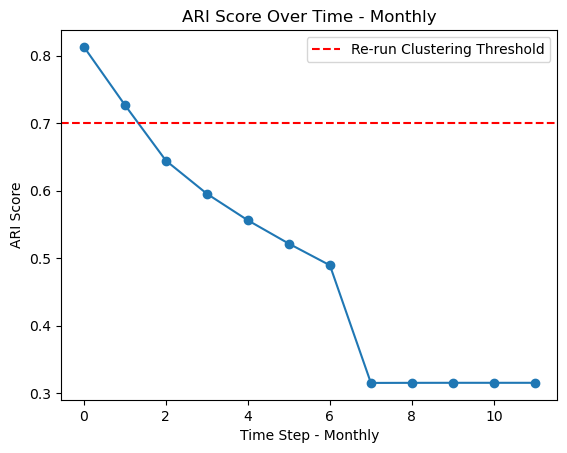

In [28]:
#taking only the values for the list
values_month = [item[1] for item in ari_score_month]

#plot ARI evolution per month
plt.plot(values_month, marker='o')
plt.xlabel('Time Step - Monthly')
plt.ylabel('ARI Score')
plt.title('ARI Score Over Time - Monthly')
plt.axhline(y=0.7, color='r', linestyle='--', label='Re-run Clustering Threshold')
plt.legend()
plt.show()

The first month shows a jump of almost 20%, we could check week by week

In [29]:
#init empty ari score
ari_score_weeks = []

#loop on each month
for p in range(1, 52):
    # Création des datasets par périodes
    start_date = pd.to_datetime('2017-01-01')
    start_T0 = pd.to_datetime('2018-01-01')
    start_date_Tp = start_T0 + relativedelta(days=+7*p)  # Incrémentation de 1 semaine
    data_period = data.copy()
    mask_data_period = (data['date_reference'] > start_date) & (
        data['date_reference'] <= start_date_Tp)
    data_period = data.loc[mask_data_period].drop(
        columns='date_reference')

    # K-Means
    kmeans_p = train_kmeans(data_period, StandardScaler(), 4)   
    p_labels = kmeans_p.named_steps['kmeans'].labels_

    # Calcul des ARI score
    ari_p = adjusted_rand_score(kmeans_init.predict(
        data_period), kmeans_p.predict(data_period))
    ari_score_weeks.append([p, ari_p])


print(ari_score_weeks)

[[1, 0.9452613098646315], [2, 0.9026093436706877], [3, 0.8712780773991533], [4, 0.8260500755344475], [5, 0.7969223727695631], [6, 0.48367227026325], [7, 0.7635388339524262], [8, 0.7328191268135416], [9, 0.48781904021839567], [10, 0.7017054172574881], [11, 0.6770059275193813], [12, 0.4866425150776364], [13, 0.6436316042490721], [14, 0.628247437928545], [15, 0.6231898148509757], [16, 0.501388202391562], [17, 0.60142644057034], [18, 0.5855004980081818], [19, 0.572984843748505], [20, 0.5611989221974587], [21, 0.5572138695486646], [22, 0.5461834297980056], [23, 0.5393227436900245], [24, 0.5293207701284467], [25, 0.5235033241229058], [26, 0.5204668539845897], [27, 0.5162583771439011], [28, 0.5134041663126628], [29, 0.5066518654610774], [30, 0.49396636220633083], [31, 0.35917587621522007], [32, 0.351349897876275], [33, 0.3393898372932866], [34, 0.31713113008117033], [35, 0.31528371039162373], [36, 0.31534426783024794], [37, 0.33743217423242594], [38, 0.3154816916028375], [39, 0.31540538130316

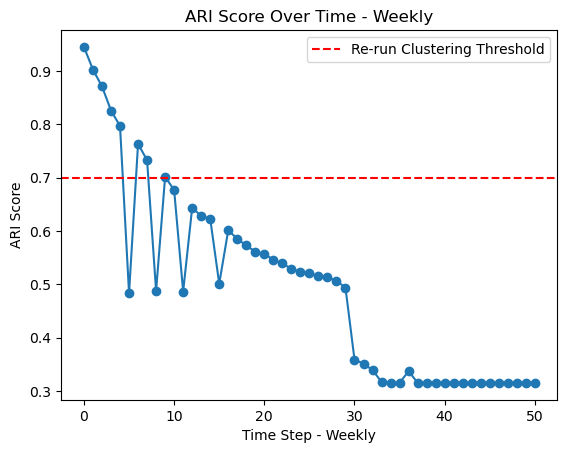

In [30]:
#taking only the values for the list
values_weeks = [item[1] for item in ari_score_weeks]

#plot ARI evolution per week
plt.plot(values_weeks, marker='o')
plt.xlabel('Time Step - Weekly')
plt.ylabel('ARI Score')
plt.title('ARI Score Over Time - Weekly')
plt.axhline(y=0.7, color='r', linestyle='--', label='Re-run Clustering Threshold')
plt.legend()
plt.show()

The 5 first weeks are somewhat stable, then on the 6th week is drops below 80% 

OFFER 1 : MAXIMUM STABILITY
Retrain and re-clustering - every 2 weeks - 
- Guaranteed precision over 90%
- Closer to your customers evolutions

OFFER 2 : EXCELLENT STABILITY
Retrain and re-clustering - every month - 
- Guaranteed precision over 80%
- Acceptable delay on customer evolution

OFFER 3 : MINIMAL STABILITY
Retrain and re-clustering - every 3 month - 
- Guaranteed precision over 65%
- Delay on customer evolution